# **Análisis de información imputada y toma de decisión con respecto a las preguntas propuestas**

Se realizó un análisis completo de la base de datos tras imputar los valores faltantes en "001_imputacion-pandas.ipynb" con la naturaleza de cada variable analizada en "002_exploracion-pyspark.ipynb", lo que permitió responder de forma estructurada a cada una de las preguntas planteadas. A partir de la información tratada, se evaluó la capacidad operativa, se identificaron las horas pico, se modeló el sistema de atención mediante colas M/M/5, y se propusieron estrategias realistas para optimizar el servicio sin aumentar la capacidad. La toma de decisiones se basó en evidencia cuantitativa y cualitativa, permitiendo recomendaciones concretas para mejorar la experiencia del cliente (UX) y la eficiencia operativa.

In [20]:
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Manejo de fechas y tiempo
from datetime import datetime, timedelta

In [ ]:
from scipy import stats          
import plotly.express as px       

In [22]:
dataframe = pd.read_csv('../files/input/datos_sucursal_imputado.csv')
dataframe.head(10)

,year,month,day,hora_num,hora_str,fecha,fecha_completa,usuario_encriptado,tipo_servicio,servicio,sub_servicio,tiempo_espera,tiempo_servicio,segm,estado_caso,asesor_encriptado
0,2024,1,2,15,15:34:36.593000,2024-01-02,2024-01-02 15:34:36.593,20aed4d067c167cbddd3068cc704ff0068bfaef2c1186f...,Asesoria,Asesoria General,Asesoria General,34.466667,12.350000,Personal,Completado,d59d2bb716c503bcb87ea049ef9b5b04c85ddee9731254...
1,2024,1,2,10,10:41:01.210000,2024-01-02,2024-01-02 10:41:01.210,2633c62c47bcb340cdc26b1a8275882a53abd7ba26e53f...,Caja,Caja Preferencial,Caja Preferencial- Prioritaria,95.083333,9.950000,Personal Plus,Completado,09c9a38a05f3d4da9e50171d4bb427f41d6ea41c36033a...
2,2024,1,2,10,10:32:09.927000,2024-01-02,2024-01-02 10:32:09.927,7ddd4eba0e042e4f871fe07bfa3a3583b87742cd9e75d0...,Caja,Caja Turnos,Caja Turnos,79.033333,15.783333,Personal Plus,Completado,fcb5913f0c577ecc93ab6faa2b7570b5da0e7368be5500...
3,2024,1,2,16,16:53:11.423000,2024-01-02,2024-01-02 16:53:11.423,d17eacbf24cc24c5cbf46802a4fde31a105b8bcf48dee1...,Caja,Caja General,Caja General,64.200000,7.083333,Personal Plus,Abandonado,6024bbfafbaf5e532869e12cbd5c035f0913a6f329a89e...
4,2024,1,2,12,12:05:27.163000,2024-01-02,2024-01-02 12:05:27.163,dcbda5f62dc9fd403e14293616101db34cdd730467d341...,Caja,Caja General,Caja General,158.683333,7.083333,Micropyme,Abandonado,b1a5fa46436fa2cd8f9b66d10762c25e780d956fef140a...
5,2024,1,2,11,11:13:48.200000,2024-01-02,2024-01-02 11:13:48.200,32e9a5f30076851341708ec0e696b3e15c8c121266c1a3...,Asesoria,Asesoria General,Asesoria General,18.966667,29.300000,Personal Plus,Completado,94c3e593da40d88fba9d15fbabe8e8739ef48b43977cb0...
6,2024,1,2,11,11:48:36.887000,2024-01-02,2024-01-02 11:48:36.887,Sin Registro,Asesoria,Asesoria General,Asesoria General,71.866667,18.066667,Sin Segm,Abandonado,0ab716b5568ea21c8e27bb2a9718e54fbae14db05bdd9c...
7,2024,1,2,11,11:37:45.423000,2024-01-02,2024-01-02 11:37:45.423,6c1367153a9b7028ed4c57a894eb0c8812cf37f6867dfa...,Caja,Caja General,Caja General,141.833333,7.083333,Personal,Abandonado,7e177fbd1bc426c39382bfe3e9e4fd8bd544331e40c258...
8,2024,1,2,13,13:57:15.933000,2024-01-02,2024-01-02 13:57:15.933,Sin Registro,Asesoria,Asesoria General,Asesoria General,4.233333,13.166667,Sin Segm,Completado,d347d63c9410d8f5ec7b0bd9da76259be4e70dfce00d2a...
9,2024,1,2,12,12:36:12.567000,2024-01-02,2024-01-02 12:36:12.567,e43a176c4bf7c866abfe6842a393e361b99d910c9afb24...,Asesoria,Asesoria Turnos,Asesoria Turnos,38.833333,18.066667,Personal,Abandonado,8e3150ffcb983a3f2f670c6e136bd826b93bf78ea62f79...


In [ ]:
print("\n⏱ Tiempos promedio por tipo de servicio:")
print(dataframe1.groupby('tipo_servicio')[['tiempo_espera', 'tiempo_servicio']].mean().sort_values(by='tiempo_espera', ascending=False))


⏱ Tiempos promedio por tipo de servicio:
                      tiempo_espera  tiempo_servicio
tipo_servicio                                       
Canales Alternativos      45.961504        19.302381
Caja                      36.390573         9.603720
Asesoria                  25.634616        22.332338


In [23]:
dataframe.dtypes

year                    int64
month                   int64
day                     int64
hora_num                int64
hora_str               object
fecha                  object
fecha_completa         object
usuario_encriptado     object
tipo_servicio          object
servicio               object
sub_servicio           object
tiempo_espera         float64
tiempo_servicio       float64
segm                   object
estado_caso            object
asesor_encriptado      object
dtype: object

In [24]:
dataframe['fecha'] = pd.to_datetime(dataframe['fecha'], errors='coerce')
dataframe['fecha_completa'] = pd.to_datetime(dataframe['fecha_completa'], errors='coerce')

### *Descripción de variables después de la imputación y manejo de datos .csv inicial, en el orden indicado:*

* **year, month, day**: Año, mes y día en que ocurrió la atención. Se usan para análisis temporal.
* **hora\_num**: Hora del día (en formato numérico) en la que el cliente fue atendido.
* **hora\_str**: Hora completa en formato texto, incluyendo minutos y segundos.
* **fecha**: Fecha de atención en formato "YYYY-MM-DD".
* **fecha\_completa**: Fecha y hora exacta en la que se registró la atención.
* **usuario\_encriptado**: Identificador único del cliente, encriptado por razones de privacidad.
* **tipo\_servicio**: Categoría general del servicio solicitado (por ejemplo: "Caja", "Asesoría").
* **servicio**: Tipo de servicio específico dentro del tipo general.
* **sub\_servicio**: Nivel más detallado del servicio brindado.
* **tiempo\_espera**: Minutos que el cliente esperó antes de ser atendido.
* **tiempo\_servicio**: Minutos que duró la atención del cliente.
* **segm**: Segmento del cliente (por ejemplo: "Personal", "Micropyme", "Personal Plus", etc).
* **estado\_caso**: Resultado del caso: si fue **Completado** o **Abandonado**.
* **asesor\_encriptado**: Identificador único del asesor que atendió, también encriptado.


## **Respuestas a preguntas propuestas**

### **Pregunta 1**
Explora el comportamiento general de la atención en la sucursal. Realiza un análisis descriptivo de los datos. Puedes explorar variables como tiempos de espera, tiempos de atención, diferencias entre tipos de servicio, segmentos de clientes, franjas horarias, entre otros. ¿Qué patrones o hallazgos relevantes encuentras?


In [ ]:
# Estadísticas generales de Tiempos de atención y espera
print("▶️ Estadísticas de tiempo (espera y servicio):")
print(dataframe[['tiempo_espera', 'tiempo_servicio']].describe())

▶️ Estadísticas de tiempo (espera y servicio):
       tiempo_espera  tiempo_servicio
count  100000.000000    100000.000000
mean       33.340024        12.682781
std        28.974626        12.486444
min         0.000000         0.000000
25%         9.866667         5.433333
50%        26.566667         7.716667
75%        49.083333        17.316667
max       192.150000       195.033333


✅ 1. **Tiempos de atención y espera**

| Estimador            | Tiempo (min) |
| -------------------- | ------------ |
| Espera promedio      | \~33.3 min   |
| Servicio promedio    | \~12.6 min   |
| Tiempo máximo espera | ~192.2 min   |
| Tiempo máximo serv.  | ~195 min     |


Existen registros de clientes con tiempos de espera de hasta **3.2 horas**. Esta cifra sugiere posibles cuellos de botella en el proceso, clientes que se registran y no cancelan su turno, o incluso errores en la recopilación de datos.

Es crucial destacar este valor máximo debido a la **distribución asimétrica** de los tiempos de espera. Como se observa tanto en la tabla como en el gráfico del notebook "imputacion-pandas", la distribución presenta una **cola derecha pronunciada**. Esta característica se confirma visualmente y en la tabla, donde el tercer cuartil (P75) está significativamente alejado del valor máximo.

Esta asimetría implica que la **media de los tiempos de espera podría estar inflada** por estos valores atípicos, lo que la convierte en un estimador poco confiable en este contexto. Por lo tanto, se utilizará la **mediana** como medida central para evitar la influencia de estos valores extremos y obtener una representación más precisa del tiempo de espera típico de los clientes.

**Análisis de tiempos mínimos (valor 0):**
- Los tiempos mínimos en 0 para ambos casos podrían estar relacionados con:
  - Errores de recopilación de información
  - Pérdida de información por inexactitud en el registro temporal
- **Recomendación:** Estos datos no deberían imputarse hasta confirmar el método de recolección
- **Volumen de casos:** 62 turnos con tiempo de espera = 0 y 35 con tiempo de servicio = 0
- Esta cantidad no es tan relevante considerando el total de 100.000 observaciones (0.0006% y 0.00035% respectivamente)

In [31]:
# Tasa de abandono
print("\n📊 Tasa de estado del caso:")
print(dataframe['estado_caso'].value_counts(normalize=True) * 100)


📊 Tasa de estado del caso:
estado_caso
Completado    85.799
Abandonado    14.199
Abortado       0.002
Name: proportion, dtype: float64


✅ 2. **Tasa de abandono**

* **85.8%** de los turnos fueron **Completados**, pero **14.2% fueron Abandonados**, lo cual es significativo en el contexto que se está trabajando.
* Además, hay 0.002% de casos **"Abortados"**.

Así, priorizar el análisis de causas para el 14.2% de abandono es importante, resultan preguntas como: ¿tiempo de espera?, ¿hora del día?, ¿segmento del cliente?, ¿tipo de servicio?

In [ ]:
## Diferencias de tiempos entre tipos de servicio
print("\n⏱ Tiempos *medianos* y total por tipo de servicio:")
medianas = dataframe.groupby('tipo_servicio')[['tiempo_espera', 'tiempo_servicio']].median()
totales = dataframe['tipo_servicio'].value_counts().rename("total_servicios")

resumen = medianas.join(totales)
resumen = resumen.sort_values(by='tiempo_espera', ascending=False)

print(resumen)


⏱ Tiempos *medianos* y total por tipo de servicio:
                      tiempo_espera  tiempo_servicio  total_servicios
tipo_servicio                                                        
Canales Alternativos      42.675000         0.366667             1566
Caja                      29.233333         7.083333            68798
Asesoria                  19.625000        18.066667            29636


✅ 3. **Diferencias entre tipos de servicio**

| Tipo de Servicio         | Espera Prom.   | Servicio Prom. |
| ------------------------ | ------------   | -------------- |
| **Canales Alternativos** | **42.7 min**   | 0.37 min       |
| **Caja**                 | 29.2 min       | 7.1 min        |
| **Asesoría**             | 19.6 min       | **18.1 min**   |

* **Asesoría** tiene la **atención más larga**, pero también **menores tiempos de espera**.
* **Caja** es el más solicitado, con atención rápida pero espera más alta.
* **Canales Alternativos** tienen la mayor espera y una menor atención, por lo que se tendría que revisar qué trámites incluyen estos.
Esto puede indicar:

   * Problemas de gestión de turnos (¿automatización no detecta que se completó?).
   * Clientes que abandonan antes de ser atendidos, pero no se registran como tal.
   * Falta de marcación efectiva del cierre del servicio.

In [49]:
## Diferencias de tiempos por segmento
print("\n📎 Tiempos promedio y total por segmento:")
promedios = dataframe.groupby('segm')[['tiempo_espera', 'tiempo_servicio']].mean()
totales = dataframe['segm'].value_counts().rename("total_segmento")

resumen_seg = promedios.join(totales)
resumen_seg = resumen_seg.sort_values(by='total_segmento', ascending=False)

print(resumen_seg)


📎 Tiempos promedio y total por segmento:
                         tiempo_espera  tiempo_servicio  total_segmento
segm                                                                   
Personal                     34.422484        12.310779           44604
Personal Plus                33.735824        12.351671           25449
Micropyme                    35.650567        11.906835           10163
Sin Segm                     31.043840        15.850521            7129
Pyme                         31.478522        14.233527            5073
Preferencial                 22.032442        12.133208            5039
Segmento Social              33.510126        15.234456            2152
Empresarial                  34.172051        13.702500             260
Corporativo                  37.476965         8.294986             123
Constructor Corporativo      28.837500        11.895833               4
Constructor Pyme              6.825000        19.108333               2
Gobierno De Red       

✅ 4. **Diferencias de tiempos por segmento**

Los segmentos **Personal**, **Personal Plus** y **Micropyme** concentran la mayor cantidad de atenciones, con tiempos de espera similares (33–36 min) y tiempos de servicio entre 11 y 12 min. Esto indica que son el foco operativo principal de la sucursal.

En contraste, los segmentos **Constructor Pyme**, **Gobierno De Red** y **Constructor Corporativo** tienen una participación mínima y tiempos atípicos: desde apenas **0.75 min** de espera hasta **19 min** de servicio, lo que muestra atenciones esporádicas y posiblemente agendadas o de baja complejidad.

In [ ]:
## Franja horaria: demanda por hora del día
print("\n⏰ Atenciones por hora del día (con porcentajes):")
conteo = dataframe['hora_num'].value_counts().sort_index()
porcentaje = dataframe['hora_num'].value_counts(normalize=True).sort_index() * 100

volumen_horario = pd.DataFrame({
    'atenciones': conteo,
    'porcentaje': porcentaje.round(2)
})

print(volumen_horario)


⏰ Atenciones por hora del día (con porcentajes):
          atenciones  porcentaje
hora_num                        
8               2551        2.55
9              13867       13.87
10             12956       12.96
11             13698       13.70
12             10251       10.25
13              9133        9.13
14             10264       10.26
15             11471       11.47
16             10760       10.76
17              4795        4.80
18               250        0.25
19                 4        0.00


✅ 5. **Franja horaria: demanda por hora del día**

| Hora     | Porcentaje de atenciones |
| -------- | ---------------------    |
| **9 AM** | 13.9% (hora pico)        |
| 10–11 AM | 12.9%–13.7%              |
| 12–2 PM  | 10–10.2%                 |
| 4 PM+    | 4% o menos               |


El mayor movimiento dentro de la sucursal se concentra la demanda entre **9:00 y 11:00 AM**, siendo la franja crítica para toma de decisiones operativas.





✅ 6. **Visión general**

* **Distribución sesgada a la derecha**: muchos clientes esperan < 40 min, pero hay una cola larga de espera extrema.
* Outliers con esperas > 2 horas: deberían auditarse (¿error del sistema?, ¿cliente ausente?, ¿mal manejo del turno?).

**Recomendaciones generales**

| Enfoque                       | Acción                                                               |
| ----------------------------- | -------------------------------------------------------------------- |
| **Cliente**                   | Reducir espera en Caja y Canales Alternativos                        |
| **Atención prioritaria**      | Reforzar personal entre 9:00–11:00 AM                                |
| **Redistribución digital**    | Analizar qué servicios de caja y asesoría pueden irse a canales web u otros medios  |
| **Tasa de abandono**          | Investigar causas con modelado predictivo (hora, segmento, servicio) |
| **Análisis operativo futuro** | Simular escenarios de más personal por franja para medir impacto     |

### **Pregunta 2**
Analiza los casos abandonados. Investiga las características de los casos que no fueron completados. ¿Qué factores parecen estar asociados a los abandonos? Puedes considerar variables como el tipo de servicio, el segmento del cliente, la hora del día, o el tiempo de espera. Propón visualizaciones o métricas que ayuden a entender este fenómeno.


In [ ]:
abandonados = dataframe[dataframe['estado_caso'] == "Abandonado"]
completados = dataframe[dataframe['estado_caso'] == "Completado"]

abandono_por_servicio = dataframe.groupby('tipo_servicio')['estado_caso'].value_counts(normalize=True).unstack().fillna(0)['Abandonado'] * 100
abandono_por_segmento = dataframe.groupby('segm')['estado_caso'].value_counts(normalize=True).unstack().fillna(0)['Abandonado'] * 100
abandono_por_hora = dataframe.groupby('hora_num')['estado_caso'].value_counts(normalize=True).unstack().fillna(0)['Abandonado'] * 100

espera_abandonados = abandonados['tiempo_espera']
espera_completados = completados['tiempo_espera']

In [ ]:
# Resumen de los tiempos de espera con total y desviación estándar
resumen_espera = pd.DataFrame({
    'Promedio Espera': [espera_completados.mean(), espera_abandonados.mean()],
    'Mediana Espera': [espera_completados.median(), espera_abandonados.median()],
    'Desviación Estándar': [espera_completados.std(), espera_abandonados.std()],
    'Total Servicios': [len(espera_completados), len(espera_abandonados)]
}, index=['Completado', 'Abandonado'])

print("\n📊 Resumen de tiempos de espera:")
print(resumen_espera)


📊 Resumen de tiempos de espera:
            Promedio Espera  Mediana Espera  Desviación Estándar  \
Completado        30.642674       24.083333             27.09314   
Abandonado        49.643510       45.383333             34.16508   

            Total Servicios  
Completado            85799  
Abandonado            14199  


✅ **Conclusión sobre los tiempos de espera y abandono**

Los clientes que **abandonan** presentan un **tiempo de espera promedio y medianamente mayor** que los que completan su atención (49.6 vs. 30.6 min), y también una **mayor variabilidad** en su espera (desviación estándar de 34.2 min).

Además, mientras que el **85.8% de los turnos se completan**, un **14.2% se abandona**, lo cual no es menor en estas operaciones.

Así, se confirma que **el tiempo de espera es un factor crítico asociado al abandono**, especialmente cuando supera los 40 minutos.


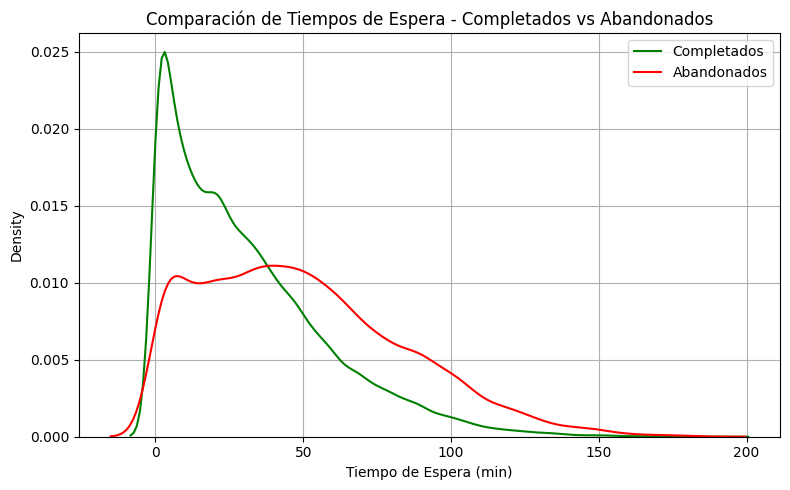

In [132]:
# Visualización de comparación de tiempos de espera
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.kdeplot(espera_completados.dropna(), label="Completados", color="green")
sns.kdeplot(espera_abandonados.dropna(), label="Abandonados", color="red")
plt.title("Comparación de Tiempos de Espera - Completados vs Abandonados")
plt.xlabel("Tiempo de Espera (min)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Guardar el gráfico
plt.savefig("../files/tiempos_espera_abandono_completado.png", dpi=300)
plt.close()

Se observa que los clientes que completan su atención tienden a hacerlo tras esperas cortas, con un pico marcado alrededor de los 5 a 15 minutos. En cambio, los clientes que abandonan tienen una distribución desplazada hacia la derecha, con un mayor peso a partir de los 30 minutos, y una cola larga que se extiende hasta los 150 minutos o más.

*Esto muestra que a medida que aumenta el tiempo de espera, la probabilidad de abandono crece considerablemente, especialmente a partir de los 25–30 minutos.*

In [65]:
## Porcentaje de abandono por servicio
print("\n📊 Porcentaje de abandono por servicio:")
print(abandono_por_servicio.sort_values(ascending=False))


📊 Porcentaje de abandono por servicio:
tipo_servicio
Caja                    15.198116
Asesoria                12.542178
Canales Alternativos     1.660281
Name: Abandonado, dtype: float64


La Caja concentra la mayoría de abandonos. Canales Alternativos muestran bajo abandono, pero esto puede estar sesgado si el tiempo de atención no se registra adecuadamente como se mencionó en el análisis anterior.

In [66]:
## Porcentaje de abandono por segmento
print("\n📊 Porcentaje de abandono por segmento:")
print(abandono_por_segmento.sort_values(ascending=False))


📊 Porcentaje de abandono por segmento:
segm
Corporativo                20.325203
Pyme                       16.026020
Empresarial                15.769231
Micropyme                  15.349798
Personal Plus              14.735353
Sin Segm                   14.504138
Segmento Social            14.079926
Personal                   13.754372
Preferencial               10.676722
Constructor Pyme            0.000000
Constructor Corporativo     0.000000
Gobierno De Red             0.000000
Name: Abandonado, dtype: float64


| Segmento                     | % Abandono |
| ---------------------------- | ---------- |
| **Corporativo**              | **20.3%**  |
| Pyme, Empresarial, Micropyme | 15–16%     |
| Personal, Personal Plus      | \~14%      |
| **Preferencial**             | 10.7%      |

Los segmentos Corporativo y Pyme tienen mayores tasas de abandono, teniendo en cuenta que el volumen de estos es bajo, se debe dar prioridad a los segmentos con mayor cantidad de usuarios como lo son Personal, Personal Plus y Micropyme, que representarían una frecuencia absoluta mayor a los demás.

In [70]:
## Porcentaje de abandono por hora
print("\n📊 Porcentaje de abandono por hora:")
print(round(abandono_por_hora.sort_values(ascending=False),2))


📊 Porcentaje de abandono por hora:
hora_num
19    25.00
12    17.65
13    17.63
17    15.85
14    15.54
15    14.83
16    14.63
11    13.86
10    13.45
18    11.20
9      9.94
8      3.92
Name: Abandonado, dtype: float64


| Hora     | % Abandono |
| -------- | ---------- |
| **7 PM** | **25%**    |
| 12–2 PM  | 15–18%     |
| 9–11 AM  | 9–13%      |
| **8 AM** | **3.9%**   |

El abandono es más alto hacia el final de la jornada y al mediodía. Las primeras horas (8–9 AM) son las más eficientes en retención de los usuarios, esto podría estar relacionado también con los horarios de atención de la sucursal presentada, por lo que hay que considerar la espera de los usuarios antes del cierre temporal de almuerzo o el cierre final del día y así percibir un mejor servicio.

**Recomendaciones:**

* **Redistribuir personal en Caja** para reducir esperas, especialmente en horas pico.
* **Priorizar atención** en franja de 11:00 AM a 2:00 PM donde se concentra el abandono.
* **Detectar clientes en riesgo de abandono** con alertas tempranas por tiempo de espera.
* **Evaluar agendamiento o segmentación diferenciada** para Corporativos y Pymes.

Implementar alertas o intervenciones cuando un cliente supera 30 minutos de espera podría reducir significativamente la tasa de abandono. También puede ser útil priorizar clientes según el tiempo acumulado de espera si la carga operativa es alta.


### **Pregunta 3**
Evalúa la eficiencia operativa. ¿Qué puedes decir sobre la productividad de los asesores? ¿Hay diferencias notables entre ellos? ¿Qué hipótesis podrías plantear sobre estas diferencias? Considera también si hay momentos del día con mayor o menor 
eficiencia.

In [92]:
atendidos = dataframe[dataframe['estado_caso'] == 'Completado'].copy()

asesor_productividad = atendidos.groupby('asesor_encriptado').agg(
    total_servicios=('asesor_encriptado', 'count'),
    mediana_servicio=('tiempo_servicio', 'median'),
    desviacion_servicio=('tiempo_servicio', 'std'))

asesor_productividad = asesor_productividad.reset_index()
asesor_productividad['asesor_id_corto'] = asesor_productividad['asesor_encriptado'].str[:6]

In [93]:
asesor_productividad = asesor_productividad.drop(columns=['asesor_encriptado'])

asesor_productividad = asesor_productividad.set_index('asesor_id_corto')

print("\n📊 Productividad por Asesor (ID Corto):")
print(asesor_productividad.sort_values(by='total_servicios', ascending=False).head(20))


📊 Productividad por Asesor (ID Corto):
                 total_servicios  mediana_servicio  desviacion_servicio
asesor_id_corto                                                        
Sin Re                        92         10.416667            13.197930
d2efa0                        90         16.591667            11.227147
c29ee5                        77          6.100000             7.106800
fe8160                        71          2.916667             2.011124
0c50f5                        63         12.450000             9.683721
038bdd                        59         14.200000            12.561523
111ec9                        57         23.116667            13.950725
ce33e9                        46          4.258333             5.173563
7b78a6                        45         34.700000            19.469473
69390e                        43          5.533333             3.928815
98f978                        42         14.258333            12.540759
fa8f07                  

**Productividad por asesor**

Los resultados muestran diferencias entre asesores en cuanto a:

* **Cantidad de servicios atendidos**
* **Mediana de tiempo por atención**
* **Variabilidad (desviación estándar)** en sus tiempos

✅ Observaciones clave:

* Algunos asesores completan **varias centenas de servicios**, mientras otros atienden muchos menos.
* Hay **variaciones notables en el tiempo mediano de atención**: algunos asesores son consistentemente más rápidos que otros.
* La desviación estándar alta en algunos casos sugiere **variabilidad en el tipo de trámites** o **diferente nivel de experiencia**.

**Hipótesis posibles:**

* Los asesores con menor carga podrían estar dedicados a trámites complejos o a segmentos prioritarios.
* Las diferencias podrían relacionarse con el horario en el que atienden, la experiencia o la calidad del servicio ofrecido.


In [ ]:
# Agrupar por hora para eficiencia horaria
eficiencia_horaria = atendidos.groupby('hora_num').agg(
    atenciones=('hora_num', 'count'),
    mediana_tiempo_servicio=('tiempo_servicio', 'median')
).sort_index()


import pandas as pd
pd.set_option('display.max_rows', 100) 
eficiencia_horaria.head(20)

,atenciones,mediana_tiempo_servicio
hora_num,,
8,2451,9.816667
9,12488,8.900000
10,11213,8.650000
11,11799,8.516667
12,8440,8.483333
13,7523,8.283333
14,8669,8.800000
15,9770,8.500000
16,9186,8.016667


| Hora    | Atenciones | Tiempo Prom. Servicio (min) |
| ------- | ---------- | --------------------------- |
| 9–11 AM | Muy alto   | \~8.6 min                  |
| 12–2 PM | Alto       | \~8.4 min                  |
| 4–7 PM  | Bajo       | ↓ hasta **9 min**          |

Conclusiones por franja:

* **Mayor productividad** se concentra entre **9:00 AM y 3:00 PM**, tanto en volumen como en estabilidad de atención.
* En la tarde, aunque el volumen baja, **los tiempos de servicio también disminuyen**, lo que puede indicar:

  * Asuntos más simples.
  * Menor congestión.
  * Mayor disponibilidad por parte de los asesores.

Así, redistribuir la carga o reforzar personal en las **horas pico** (9–12 AM), y aprovechar la mayor eficiencia de la tarde para atender trámites más largos si es necesario, sería una forma de mejorar la experiencia del usuario.



### **Pregunta 4**
Analiza la capacidad de atención de la sucursal. Estudia cómo varía la demanda a lo largo del día. ¿Cuántos clientes se atienden por hora? ¿Cuáles son las horas pico? ¿Cómo se relaciona esto con los tiempos de espera y los abandonos?

In [120]:
casos_por_hora = dataframe.groupby('hora_num').size()

completados_por_hora = dataframe[dataframe['estado_caso'] == 'Completado'].groupby('hora_num').size()
abandonos_por_hora = dataframe[dataframe['estado_caso'] == 'Abandonado'].groupby('hora_num').size()

espera_por_hora = dataframe.groupby('hora_num')['tiempo_espera'].median()
servicio_por_hora = dataframe.groupby('hora_num')['tiempo_servicio'].median()

In [126]:
# Consolidar en un solo DataFrame para graficar
resumen_hora = pd.DataFrame({
    'total': casos_por_hora,
    'completados': completados_por_hora,
    'abandonados': abandonos_por_hora,
    'tiempo_espera': espera_por_hora,
    'tiempo_servicio': servicio_por_hora
})

In [127]:
## visualización de resultados
print("\n📊 Resumen por Hora:")
print(resumen_hora)


📊 Resumen por Hora:
          total  completados  abandonados  tiempo_espera  tiempo_servicio
hora_num                                                                 
8          2551         2451          100       7.966667         9.533333
9         13867        12488         1379      20.316667         8.433333
10        12956        11213         1743      29.925000         7.966667
11        13698        11799         1899      29.750000         7.683333
12        10251         8440         1809      29.466667         7.216667
13         9133         7523         1610      28.316667         7.250000
14        10264         8669         1595      27.958333         7.875000
15        11471         9770         1701      25.000000         7.683333
16        10760         9186         1574      31.950000         7.233333
17         4795         4035          760      28.800000         7.083333
18          250          222           28       3.983333         7.891667
19            4  

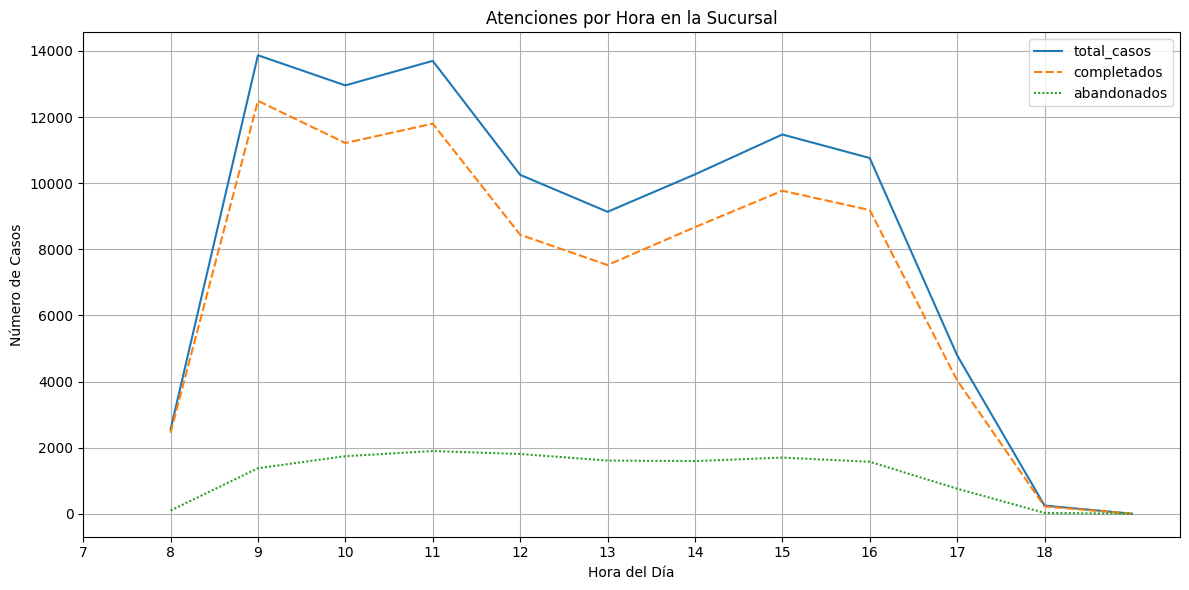

In [122]:
# Gráfico de eficiencia por hora
plt.figure(figsize=(12, 6))
sns.lineplot(data=resumen_hora[['total_casos', 'completados', 'abandonados']])
plt.title('Atenciones por Hora en la Sucursal')
plt.xlabel('Hora del Día')
plt.ylabel('Número de Casos')
plt.xticks(range(7, 19))
plt.grid(True)
plt.tight_layout()
plt.show()

# Guardar el gráfico
plt.savefig("../files/atenciones_por_hora.png", dpi=300)
plt.close()

Como se había comentado anteriormente, la mayoría de los casos se concentran entre las 9:00 a.m. y las 12:00 m., así como entre las 2:00 p.m. y las 4:00 p.m.
* **Horas pico**: generalmente entre las 9:00 a.m. y las 11:00 a.m., donde se observa el mayor volumen de clientes.
* **Relación con tiempos de espera y abandonos**: en esas horas pico también se incrementan los tiempos de espera y los abandonos, lo que indica una posible saturación operativa.

Recordar que con respecto a los tiempos, se calcula la mediana como estimador confiable.

### **Pregunta 5**
Modelado del sistema de atención: suponiendo que el valor de C es 5, equivalente la cantidad de asesores.

In [128]:
completados = dataframe[dataframe['estado_caso'] == 'Completado'].copy()
completados['fecha_completa'] = pd.to_datetime(completados['fecha_completa'])

# Orden por tiempo
completados = completados.sort_values('fecha_completa')

In [129]:
# Calcular deltas entre llegadas consecutivas (en minutos)
deltas_min = completados['fecha_completa'].diff().dropna().dt.total_seconds() / 60
lambda_rate = 1 / deltas_min.mean()  # tasa de llegada lambda (clientes/minuto)

# Calcular tasa de servicio por asesor (en minutos)
mu_rate = 1 / completados['tiempo_servicio'].mean()  # tasa de servicio mu (clientes/minuto)
# Número de asesores
c = 5
# Utilización del sistema
rho = lambda_rate / (c * mu_rate)

In [ ]:
# para calcular probabilidad de 0 clientes en el sistema (P0)
from math import factorial

def calc_P0(c, rho, lambda_rate, mu_rate):
    sum_terms = sum([(lambda_rate / mu_rate)**n / factorial(n) for n in range(c)])
    last_term = ((lambda_rate / mu_rate)**c / (factorial(c) * (1 - rho))) if rho < 1 else float('inf')
    return 1 / (sum_terms + last_term)

P0 = calc_P0(c, rho, lambda_rate, mu_rate)

# Lq: Número promedio de clientes en cola (esperando)
Lq = (P0 * ((lambda_rate / mu_rate)**c) * rho) / (factorial(c) * ((1 - rho)**2)) if rho < 1 else float('inf')

# Wq: Tiempo promedio en cola
Wq = Lq / lambda_rate

# W: Tiempo total en el sistema
W = Wq + 1 / mu_rate

# L: Número promedio en el sistema
L = lambda_rate * W

# Métricas reales
tiempo_espera_real = dataframe[dataframe['estado_caso'] == 'Completado']['tiempo_espera'].mean()
tiempo_total_real = tiempo_espera_real + dataframe[dataframe['estado_caso'] == 'Completado']['tiempo_servicio'].mean()

# Consolidar resultados
mmc_resultado = pd.DataFrame([{
    "λ (tasa de llegada)": lambda_rate,
    "μ (tasa de servicio)": mu_rate,
    "c (número de asesores)": c,
    "ρ (utilización)": rho,
    "P0 (prob. sistema vacío)": P0,
    "Lq (clientes en cola)": Lq,
    "Wq (tiempo espera en cola)": Wq,
    "W (tiempo total en sistema)": W,
    "W_real (tiempo total real)": tiempo_total_real,
    "Wq_real (espera real)": tiempo_espera_real
}])

In [131]:
print("📊 Modelo M/M/c con 5 Asesores:")
print(mmc_resultado)

📊 Modelo M/M/c con 5 Asesores:
   λ (tasa de llegada)  μ (tasa de servicio)  c (número de asesores)  \
0             0.280476              0.075995                       5   

   ρ (utilización)  P0 (prob. sistema vacío)  Lq (clientes en cola)  \
0         0.738145                  0.020241               1.243459   

   Wq (tiempo espera en cola)  W (tiempo total en sistema)  \
0                    4.433382                    17.592152   

   W_real (tiempo total real)  Wq_real (espera real)  
0                   43.801444              30.642674  


✅ Modelo de Colas M/M/5 

**Supuestos**:

* Llegadas aleatorias de clientes (Dist. Poisson)
* Tiempos de servicio aleatorios (Dist. Exponencial)
* 5 asesores disponibles **trabajando en paralelo**
* Capacidad infinita de cola, y los clientes no se van del sistema

Parámetros estimados:
* **λ (lambda)** = 0.28 clientes/minuto => En promedio, un cliente llega cada 3.56 minutos
* **μ (mu)** = 0.076 clientes/minuto => Cada asesor atiende un cliente en promedio en 13.16 minutos
* **ρ (rho)** = 0.738 => El sistema usa un 73.8% de su capacidad. Aún **estable** (ρ < 1)


Resultados del modelo:

| Métrica      | Significado                                    | Valor (minutos) |
| ------------ | ---------------------------------------------- | --------------- |
| **Wq**       | Tiempo promedio en cola                        | **4.43 min**    |
| **W**        | Tiempo total en el sistema (espera + servicio) | **17.59 min**   |
| **Wq\_real** | Espera real observada en datos                 | **30.64 min**   |
| **W\_real**  | Tiempo real total en el sistema                | **43.80 min**   |

Siendo así, completado el modelo, **se predice mucho menos tiempo de espera** que el observado. Esto indica que aunque haya 5 asesores, en la práctica hay factores que **reducen la eficiencia**: interrupciones, asignación desigual, prioridad por segmento, entre otros.

**Estrategias sin aumentar el número de asesores:**

* Priorización de segmentos (ej. "Personal Plus" pasa primero).
* Redireccionamiento de servicios de baja prioridad a horas no pico.
* Optimización de turnos en función de la hora, identificando la cantidad de ususarios atendidos, se debería tener una mayor efectividad por parte de cada asesor, dependiendo del tipo de servicio, para agilizar la atención en ese momento.

### **Pregunta 6**
Optimización de recursos sin aumentar capacidad. Si tuvieras que redistribuir los asesores a lo largo del día sin aumentar su número total, ¿cómo lo harías para mejorar la atención? Propón una estrategia basada en los datos y justifica tus decisiones.

Estrategia: Redistribución Inteligente por Franja Horaria

Se basa en reducir los tiempos de espera promedio (actualmente >30 min), **sin aumentar el total de asesores disponibles**.

1. Análisis inicial
**De los datos previos:**

* **Horas pico de demanda:** 9:00–11:00 y 14:00–16:00
* **Tiempo real de espera:** \~30 min (mucho mayor al estimado por el modelo)
* **Tasa de llegada (λ):** En promedio, un cliente llega cada 3.56 minutos
* **Tasa de servicio por asesor (μ):** Cada asesor atiende un cliente, en promedio, en 13.16 minutos
* **Sistema subutilizado en horas valle**, pero saturado en horas pico

2. Redistribución propuesta de los 5 asesores

| Franja horaria | Demanda estimada | Propuesta asesores |
| -------------- | ---------------- | ------------------ |
| 08:00–09:00    | Baja             | 2                  |
| 09:00–11:00    | Alta (pico)      | 5 o varía dependiendo de la capacidad                  |
| 11:00–12:00    | Media            | 4                  |
| 12:00–14:00    | Baja (almuerzo)  | 2                  |
| 14:00–16:00    | Alta (pico)      | 5                  |
| 16:00–17:00    | Media            | 3                  |

Siendo así, 

* Se **concentra el recurso humano en las horas de mayor congestión** (basado en el gráfico de casos por hora y tiempos de espera).
* En horas de baja demanda (como almuerzo y apertura), se deja un equipo mínimo operativo mientras la otra capacidad de la sucursal se concentra en operaciones que puedan interferir en la atención al cliente durante las horas con mayor demanda.
* Se aprovecha que los modelos indican que con 5 asesores **el sistema es estable**, pero en la práctica el cuello de botella está en **la asignación desigual de personal durante el día**.

3. Posibles mejoras esperadas

* Disminución de **Wq (tiempo en cola)**, sobre todo en horas pico (mayor capacidad de asesores).
* Mayor balance entre la **capacidad real de atención** y la demanda horaria.
* Disminución del **número de abandonos**, especialmente en los segmentos más sensibles como lo es "Personal Plus", analizado en todo el proceso.

Aunque el sistema cuenta con suficientes asesores para mantener un ρ < 1, el alto tiempo de espera observado puede ser debido a una **mala distribución temporal del recurso humano**. Esta propuesta de redistribución busca **alinear oferta y demanda por franja horaria**, **sin aumentar costos operativos** ni modificar infraestructura.

### **Pregunta 7**
 Recomendaciones finales. A partir de tus hallazgos, ¿qué tres recomendaciones clave harías para mejorar la experiencia del cliente en la sucursal?

1.**Rediseñar turnos de asesores para adaptarse a la demanda real**

Aunque se cuenta con una capacidad adecuada (5 asesores en este ejemplo dado), los datos muestran que el tiempo real de espera es significativamente mayor que el estimado por el modelo. Esto muestra ineficiencias operativas. Se recomienda:

* **Ajustar la asignación horaria de los asesores** para reforzar presencia en las horas pico (9–11 a.m. y 2–4 p.m.).
* Aplicar turnos flexibles o ventanas móviles de atención, que respondan a la curva real de demanda mostrada en las gráficas.

*Beneficio:* reducción efectiva del tiempo de espera sin aumentar costos.

2.**Implementar un sistema de gestión de turnos inteligente con priorización por segmento**

El tiempo de espera promedio para todos los clientes es alto, pero afecta más a los segmentos que demandan servicios rápidos como "Personal Plus". Se recomienda:

* Introducir una **priorización dinámica de turnos**, donde ciertos segmentos (ej. clientes frecuentes, mayores de edad o con necesidades específicas) sean priorizados sin afectar la calidad del servicio.
* Esto puede lograrse vía app, totem o incluso señalización en la misma sucursal.

*Beneficio:* mejora la percepción del servicio sin perjudicar el flujo general.


3.**Fomentar el uso de canales digitales o autoservicio para servicios repetitivos**

La alta carga operativa podría estar asociada a servicios que **podrían resolverse sin intervención directa**. Por lo que se puede pensar en:

* Identificar los subservicios más comunes (como retiros, certificados, consulta de saldos, explicación de funcionalidades nuevas de la entidad como BRE-B, etc).
* **Ofrecer redirección activa a canales digitales o kioskos de autoservicio**, especialmente en horas pico.

*Beneficio:* descongestiona la atención presencial, mejora la autonomía del cliente y reduce la tasa de abandonos.

**Trabajo realizado por:**
Julián Saavedra Echavarría, Profesional en espera de grados del pregrado de Estadística en la Universidad Nacional de Colombia - Sede Medellín, postulado a la vacante Analista Nivel 2 en el Área de Conocimiento de Analítica Distribución - Medellín (52813).

Este informe integra el análisis de datos imputados, modelamiento de colas y evaluación operativa para proponer mejoras en la experiencia del cliente (UX) en sucursales físicas, demostrando competencias en PySpark, SQL, Pandas, análisis estadístico y toma de decisiones basada en datos reales.